# Exercise 1 - Maximum Entropy Distribution problem with prior assumptions

Consider a random variable $X$ with values in the finite set $\{\alpha_1,\dots,\alpha_n\}$. The distribution of $X$ is characterized by $p$, as $\textbf{prob}(X=\alpha_k)=p_k$. Clearly $p$ satisfies $p\succeq 0$, $\mathbf{1}^\top p=1$. 

The so-called *Maximum Entropy Distribution problem with prior assumptions* can be formulated as

$$
\begin{array}{ll}
\displaystyle \max_{p} & -\sum_{i=1}^n p_i \log(p_i)\\
s.t. & p \in \mathcal{P}.
\end{array}
$$

where $\mathcal{P}$ represents a convex set expressing prior information.

We consider a set of equidistant points $\alpha_i$ in the interval $[-1,1]$:

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

#Data
n = 100
alpha = np.linspace(-1,1,n)

And we assume the following prior information:

$$
E(X) \in [-0.1,0.1]
$$
$$
E(X^2) \in [0.5,0.6]
$$
$$
E(3X^3-2X) \in [-0.3,-0.2]
$$
$$
\textbf{prob}(X<0) \in [0.3,0.4]
$$

Recall that $E(f(X)) = \sum_{i} f(\alpha_i) \cdot p_i$ and that $\textbf{prob}(X< 0)$ is given by the Python command `(alpha<0).astype(int)*p`, where `p` is the cp variable.

1.   Solve the Maximum Entropy Distribution problem with prior information (Hint: it is advised that you use the atomic function [entr](https://www.cvxpy.org/api_reference/cvxpy.atoms.elementwise.html?highlight=entr#cvxpy.atoms.elementwise.entr.entr)). What is the optimal value?
2.   Plot $\textbf{prob}(X = \alpha_i)$ vs $\alpha_i$.

## Solution 1

In [ ]:
P = cp.Variable(n)

objective = cp.Maximize(cp.sum(cp.entr(P)))

constraints = [
    P >=0,
    cp.sum(P) == 1,
    cp.sum((alpha @ P)) >= -0.1,
    cp.sum((alpha @ P)) <= 0.1,

    cp.sum(((alpha**2) @ P)) >= 0.5,
    cp.sum(((alpha**2) @ P)) <= 0.6,

    cp.sum(((3*(alpha**3)) @ P - 2*alpha@P)) >= -0.3,
    cp.sum(((3*(alpha**3)) @ P - 2*alpha@P)) <= -0.2,

    cp.sum(((alpha<0).astype(int)@P)) >= 0.3,
    cp.sum(((alpha<0).astype(int)@P)) <= 0.4,
]

prob = cp.Problem(objective,constraints)
prob.solve(verbose=False)
print("status:", prob.status)
print("Optimal value", prob.value)

status: optimal
Optimal value 4.386294336261325


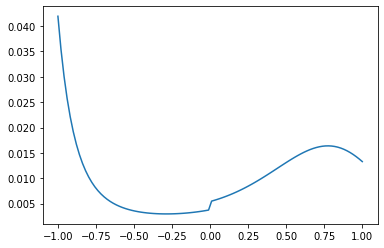

In [ ]:
import matplotlib.pyplot as plt

plt.plot(alpha,P.value)

# Exercise 2 - Censored Data


In statistics, [censoring](https://en.wikipedia.org/wiki/Censoring_(statistics)) is a condition in which the value of a measurement or observation is only partially known. 

For instance, suppose a study is conducted to measure the impact of a drug on mortality rate. In such a study, it may be known that an individual's age at death is at least 75 years (but may be more). Such a situation could occur if the individual withdrew from the study at age 75, or if the individual is currently alive at the age of 75.

Censoring also occurs when a value occurs outside the range of a measuring instrument. For example, a bathroom scale might only measure up to 140 kg. If a 160-kg individual is weighed using the scale, the observer would only know that the individual's weight is at least 140 kg. 



We wish to fit a set of data points,

$$
(x^{(1)},y^{(1)}), \dots , (x^{(K)},y^{(K)}),
$$

with $x^{(k)}\in \mathbb{R}^n$ and $y^{(k)} \in \mathbb{R}$, with a linear model of the form $y \approx c^\top x$. The vector $c\in\mathbb{R}^n$ is the model parameter, which we want to choose. We will use a least-squares criterion, i.e., choose $c$ to minimize

$$
J = \sum_{k=1}^K \left( y^{(k)} - c^\top x^{(k)} \right)^2
$$

All the values of $x^{(k)}$ are known. The data $y^{(1)}$, ..., $y^{(M)}$ are known, while the data $y^{(M+1)}$, ..., $y^{(K)}$ are all censored, i.e. unknown but larger than $D$, a known number.

Solve three problems:



1.   Solve the naive Least-Square problem (i.e. minimize $J$) considering the entire data from $1$ to $K$ as if it were correct (i.e. assume that the censored data is the actual data)
2.   Solve the Least-Squares problem ignoring the censored data, i.e. use only the data from $1$ to $M$
3.   Use constraints to take into account the censored data

For each of the problems compute the residual

$$
\frac{||c_{true} - \hat c||_2}{||c_{true}||_2}
$$

where $c_{true}$ is the actual value of $c$ and $\hat c$ is the estimated value in each of the three problems.

The data is generated by this snippet of code

In [ ]:
# This code generates the data for the problem
# The variables that you can use are X_ordered, y_censored and D.
# You can use c_true to compute the residual
# DO NOT USE X, y and y_ordered, these are internal variables
# used to generate the data for the problem

import cvxpy as cp
import numpy as np
n = 30 # number of variables
M = 50 # number of uncensored observations
K = 200 # total number of observations

# Random generation of the data
np.random.seed(n*M*K)
X = np.random.randn(K*n).reshape(K, n) # DO NOT USE
c_true = np.random.rand(n)
y = X.dot(c_true) + .3*np.sqrt(n)*np.random.randn(K) # DO NOT USE

# Ordering them based on y
order = np.argsort(y) # DO NOT USE
y_ordered = y[order] # DO NOT USE
X_ordered = X[order,:]

# finding boundary
D = (y_ordered[M-1] + y_ordered[M])/2.

# applying censoring
y_censored = np.concatenate((y_ordered[:M], np.ones(K-M)*D))

# The variables that you can use are X_ordered, y_censored and D.
# You can use c_true to compute the residual
# DO NOT USE X, y and y_ordered, these are internal variables
# used to generate the data for the problem

## Solution 2

In [ ]:
# can use c_true, X_ordered

# 1- Ignore existence of censoring
c = cp.Variable(n)

#objective = cp.Minimize(cp.sum_squares(y- c.T @ X_ordered))

objective = cp.Minimize(cp.norm2(y_censored -  X_ordered@ c))

prob = cp.Problem(objective)

prob.solve()
print("status:", prob.status)
print("Optimal value", prob.value)
print("Optimal var c :", c.value, c.shape)

#residual = np.sum(np.square(c_true - c.value))/np.sum(np.square(c_true))

residual = np.linalg.norm(c_true-c.value)/np.linalg.norm(c_true)
c_value_1 = c.value
print("Residual is", residual)

status: optimal
Optimal value 41.21798477210766
Optimal var c : [ 0.21675412 -0.01055401  0.6084366   0.38871172 -0.02505805 -0.32893498
 -0.04523541 -0.13816865  0.48735647 -0.00860644  0.22483505  0.1980222
  0.23656382  0.22497391  0.06820719  0.10749049 -0.1314469   0.00584045
  0.04698078 -0.08254453  0.30340207  0.09028037 -0.20223001  0.18510921
  0.49060366  0.18815787  0.05200329  0.3670569  -0.034346    0.1419044 ] (30,)
Residual is 0.8381563144021161


In [ ]:
#2 Use data up to index M
c = cp.Variable(n)
objective = cp.Minimize(cp.norm2(y_censored[:M] -  X_ordered[:M]@ c))

prob = cp.Problem(objective)

prob.solve()
print("status:", prob.status)
print("Optimal value", prob.value)
print("Optimal var c :", c.value, c.shape)

#residual = np.sum(np.square(c_true - c.value))/np.sum(np.square(c_true))

residual = np.linalg.norm(c_true-c.value)/np.linalg.norm(c_true)

c_value_2 = c.value

print("Residual is", residual)

status: optimal
Optimal value 5.804982935751005
Optimal var c : [ 0.72956219  0.59273637  1.49803854  1.26515038  0.90959927  0.27911708
  0.33039085  0.58718121  0.10692683  0.69727413  1.21295263  0.92209524
  0.62076821  0.74019248  0.01724733  0.758353   -0.3686797   1.45235794
  0.00563295  1.35378805  0.78189158  0.34821785 -0.18566106  0.4954472
  0.91181214  0.79014362  1.25547097  0.51207478  1.21229208  0.40918099] (30,)
Residual is 0.6752336824029347
